In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct
import os
from sklearn.metrics import mean_squared_error
from sewar.full_ref import vifp
import time

import warnings
warnings.filterwarnings("ignore")

from corrupt import *

In [2]:
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
# data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [3]:
# fraction = fraction of noise to be added, either 0 or 0.05

def noise(image, fraction):
    kspace = transform_image_to_kspace(image)
    
    mag_re = fraction*np.std(np.real(kspace))
    mag_im = fraction*np.std(np.imag(kspace))
    noise = np.random.normal(0, mag_re, size=np.shape(kspace)) + 1j*np.random.normal(0, mag_im, size=np.shape(kspace))
    kspace += noise
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [4]:
# acceleration = acceleration rate, either 2, 3 or 4

def downsample(image, acceleration):
    kspace = transform_image_to_kspace(image)
    
    center_fraction = 0
    if acceleration == 2:
        center_fraction = 0.16
    elif acceleration == 3:
        center_fraction = 0.12
    elif acceleration == 4:
        center_fraction = 0.08

    mask = cartesian_mask((acceleration, center_fraction), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))
    kspace = np.where(mask, kspace, (0 + 0j))
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [5]:
def rigid_motion(image, pe_direction, n_movements, ang_std, trans_std, corrupt_pct_range):
    # normalize the image from 0 to 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # phase encoding direction
    if (pe_direction == "LR"):
        grid_size = image.shape[1]
    elif (pe_direction == "AP"):
        grid_size = image.shape[0]
    
    # locations of the movements
    # corrupt_pct_range = np.random.uniform(0, 0.3*(100/(100-7))) #little over 30 %, because centre part will be masked
    corrupt_lines = np.maximum(n_movements, round(corrupt_pct_range*grid_size))
    clean_lines = grid_size - corrupt_lines
    locs_corrupt = np.sort(np.append(np.random.permutation(corrupt_lines)[:(n_movements)], (0, corrupt_lines)))
    locs_clean = np.sort(np.append(np.random.permutation(clean_lines)[:(n_movements)], (0, clean_lines)))
    locs = [0]
    seg = 0
    for i in range(n_movements):
        seg += locs_clean[i+1] - locs_clean[i]
        locs.append(seg)
        seg += locs_corrupt[i+1] - locs_corrupt[i]
        locs.append(seg)
    
    # rotation and translation parameters
    ang = np.random.normal(0, ang_std, n_movements)
    trans_x = np.random.normal(0, trans_std, n_movements)
    trans_y = np.random.normal(0, trans_std, n_movements)

    # combine kspaces
    kspace_clean = transform_image_to_kspace(image)
    kspace = np.copy(kspace_clean)
    for i in range(n_movements):
        img_i = combining_transforms(image, ang[i], trans_x[i], trans_y[i])
        kspace_i = transform_image_to_kspace(img_i)
        if (pe_direction == "LR"):
            kspace[:, locs[i*2+1]:locs[i*2+2]] = kspace_i[:, locs[i*2+1]:locs[i*2+2]]
        elif (pe_direction == "AP"):
            kspace[locs[i*2+1]:locs[i*2+2], :] = kspace_i[locs[i*2+1]:locs[i*2+2], :]
    
    # mask centre
    pct = 0.07 # percentage center k-space without motion
    num_low_frequencies = round(pct*grid_size) # lines center k-space without motion
    begin = round(grid_size/2-num_low_frequencies/2)
    end = round(grid_size/2+num_low_frequencies/2)
    if (pe_direction == "LR"):
        kspace[:, begin:end] = kspace_clean[:, begin:end]
    elif (pe_direction == "AP"):
        kspace[begin:end, :] = kspace_clean[begin:end, :]
    
    return kspace

In [6]:
# corrupt_pct_range = range of k-space lines to be corrupted, between 0 and 0.32 (= 30 % with center k space masked)
def apply_rigid_motion(image, corrupt_pct_range):

    kspace = rigid_motion(image, random.choice(["LR", "AP"]), np.random.randint(1, 9), 3, 10, corrupt_pct_range)
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [7]:
def periodic_motion(kspace, delta, ky0):
    x = np.linspace(-np.pi, np.pi, kspace.shape[1])
    y = np.linspace(-np.pi, np.pi, kspace.shape[0])
    kx, ky = np.meshgrid(x, y)

    # parameters
    alpha = np.random.uniform(0.1, 5) # respiratory frequency
    #delta = np.random.uniform(0, 20) # shift along PE direction
    beta = np.random.uniform(0, np.pi/4) # phase
    #ky0 = np.random.uniform(np.pi/10, np.pi/2) # center K-space lines without phase shift errors
    
    # phase error outside of center
    phase_error = ky*delta*np.sin(alpha*ky + beta)
    
    # no motion in the center of k-space
    phase_error[abs(ky) < ky0] = 0

    # add phase error to k-space
    kspace = kspace*np.exp(-1j*phase_error)

    return kspace

In [8]:
# delta = shift along PE direction, between 0 and 20
# ky0 = masked center k-space, between np.pi/10, and np.pi/2
def apply_periodic_motion(image, delta, ky0):
    kspace = transform_image_to_kspace(image)
    
    kspace = periodic_motion(kspace, delta, ky0)
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [15]:
def GetFields(image, bias_rng):    
    down_size = np.int32(np.divide(image.shape, 10))
    x = np.arange(down_size[0])
    y = np.arange(down_size[1])
    
    len_scale = np.random.uniform(10, 50)
    model = Gaussian(dim=2, var=50, len_scale=len_scale)

    srf = SRF(model)

    grid_z = srf((x, y), mesh_type='structured')
    grid_z = dct2(grid_z)
    
    #bias_rng = np.random.uniform(0.20, 0.8)
    grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                       (1 - bias_rng / 2, 1 + bias_rng / 2))
    
    return grid_z

In [16]:
# bias_rng = bias range, between 0.2 and 1.0
def bias(image, bias_rng):
    
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    bias = GetFields(image, bias_rng)
    img = np.multiply(image, bias)
    kspace = transform_image_to_kspace(img)
    
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [18]:
def corrupt(image, case, fraction, acceleration, corrupt_pct_range, delta, ky0, bias_rng):
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        mag_re = fraction*np.std(np.real(kspace))
        mag_im = fraction*np.std(np.imag(kspace))
        noise = np.random.normal(0, mag_re, size=np.shape(kspace)) + 1j*np.random.normal(0, mag_im, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        center_fraction = 0
        if acceleration == 2:
            center_fraction = 0.16
        elif acceleration == 3:
            center_fraction = 0.12
        elif acceleration == 4:
            center_fraction = 0.08
        mask = cartesian_mask((acceleration, center_fraction), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "rigid_motion":
        kspace = rigid_motion(image, random.choice(["LR", "AP"]), np.random.randint(1, 9), 3, 10, corrupt_pct_range)
        
    elif case == "periodic_motion":
        kspace = periodic_motion(kspace, delta, ky0)
            
    elif case == "bias":
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        bias = GetFields(image, bias_rng)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

(-0.5, 319.5, 319.5, -0.5)

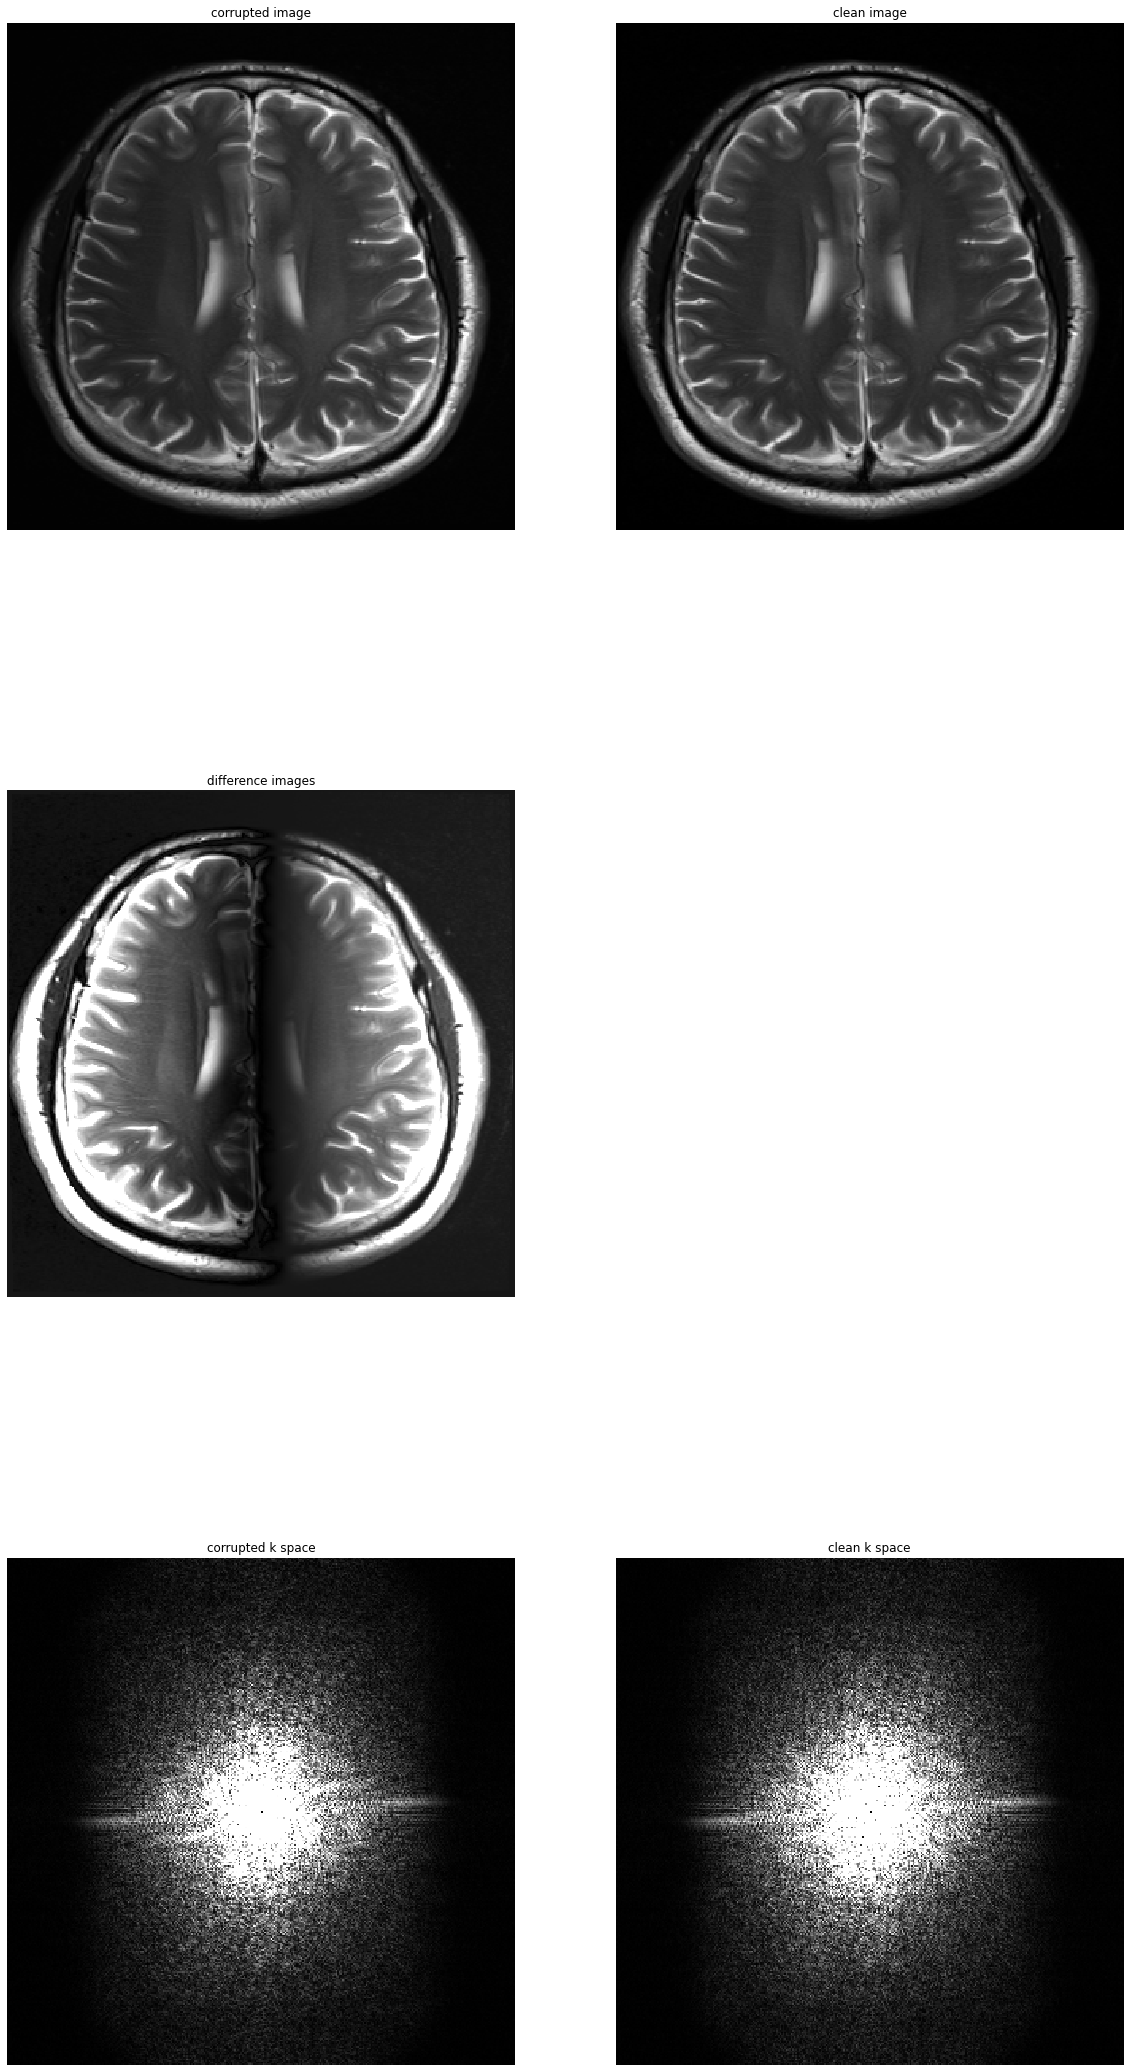

In [19]:
# plotting

#img = noise(image, 0.05)
#img = downsample(image, 4)
#img = apply_rigid_motion(image, 0.32)
#img = apply_periodic_motion(image, 20, np.pi/10)
#img = bias(image, 1.0)
img = corrupt(image, "bias", 0.05, 4, 0.32, 20, np.pi/10, 1.0)

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')